<a href="https://colab.research.google.com/github/Sambitdash25/MachineLearning/blob/master/Song_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#starts here

In [1]:
import os
import librosa
import math
import json

DATASET_PATH = "/content/drive/My Drive/genres_original"
JSON_PATH = "data.json"

SAMPLE_RATE=22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE* DURATION

def save_mfcc(dataset_path,json_path,n_mfcc=13,n_fft=2048,hop_length=512,num_segments=5):

  #dictionary to store data
  data={
      "mapping":[],
      "mfcc":[],
      "labels":[]
  }
  num_samples_per_segment = int(SAMPLES_PER_TRACK/num_segments)
  expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

  #loop through the folders and analyze the song
  for i,(dirpath,dirnames,filenames) in enumerate(os.walk(dataset_path)):
    
    #ensure that we are not at root label
    if dirpath is not dataset_path:

      #save the semantic labels such as the data stored in mapping -> "blues","classical"
      dirpath_components = dirpath.split("/") # genre/blues => ["genre","blues"]
      semantic_label = dirpath_components[-1]
      data["mapping"].append(semantic_label)
      print("\nProcessing {}".format(semantic_label))

      #process files for a specific genre
      for f in filenames:

        file_path = os.path.join(dirpath,f)
        signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)

        #process segments extracting mfcc and storing data
        for s in range(num_segments):
          start_sample= num_samples_per_segment * s
          finish_sample= start_sample + num_samples_per_segment
          
          
          mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                      sr=sr,
                                      n_fft=n_fft,
                                      n_mfcc=n_mfcc,
                                      hop_length=hop_length)
          mfcc = mfcc.T

          #store mfcc for segment if it has the expected length
          if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)
            print("{},segment:{}".format(file_path,s))


  with open(json_path,"w") as fp:
    json.dump(data,fp,indent=4)

if __name__ == "__main__":
  save_mfcc(DATASET_PATH,JSON_PATH,num_segments=10)



Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/genres_original/hiphop/hiphop.00097.wav,segment:9

Processing jazz
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:0
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:1
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:2
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:3
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:4
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:5
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:6
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:7
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:8
/content/drive/My Drive/genres_original/jazz/jazz.00008.wav,segment:9
/content/drive/My Drive/genres_original/jazz/jazz.00005.wav,segment:0
/content/drive/My Drive/genres_original/jazz/jazz.00005.wav,segment:1
/content/drive/My 

In [ ]:
#video 13

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               865792    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
219/219 [==============================] - 2s 10ms/step - loss: 6.8865 - accuracy: 0.3215 - val_los

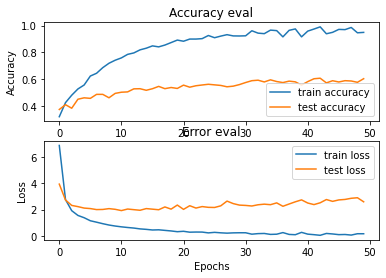

In [ ]:
#load json data for model training

import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATASET_PATH = '/content/data.json'

def load_data(dataset_path):
  with open(dataset_path,"r") as fp:
    data=json.load(fp)

  inputs = np.array(data["mfcc"])
  targets = np.array(data["labels"])

  return inputs,targets
def plot_history(history):

  fig,axs = plt.subplots(2)

  #accuarcy subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  #error subplot
  axs[1].plot(history.history["loss"],label="train loss")
  axs[1].plot(history.history["val_loss"],label="test loss")
  axs[1].set_ylabel("Loss")
  axs[1].set_xlabel("Epochs")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  plt.show()


if __name__ == "__main__":

  #load data
  inputs,targets = load_data(DATASET_PATH)

  #split data into training and testing
  inputs_train,inputs_test,targets_train,targets_test = train_test_split(inputs,targets,test_size=.3)

  #building the neural network
  model = keras.Sequential([
                            keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2])),
                            keras.layers.Dense(512,activation='relu'),
                            keras.layers.Dense(256,activation='relu'),
                            keras.layers.Dense(64,activation='relu'),
                            keras.layers.Dense(10,activation='softmax')
  ])


  #compilng the model
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  model.summary()

  #train the model
  history = model.fit(inputs_train,targets_train,validation_data=(inputs_test,targets_test),
            epochs=50,
            batch_size=32)
  
  #plot the graphs
  plot_history(history)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

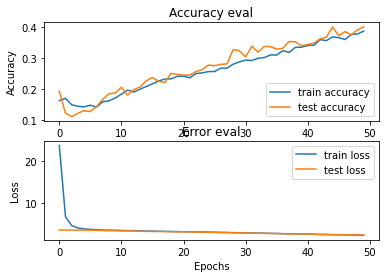

In [ ]:
#copy of previous cell for reducing over fitting
#use of dropouts and regularization
#load json data for model training

import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATASET_PATH = '/content/data.json'

def load_data(dataset_path):
  with open(dataset_path,"r") as fp:
    data=json.load(fp)

  inputs = np.array(data["mfcc"])
  targets = np.array(data["labels"])

  return inputs,targets
def plot_history(history):

  fig,axs = plt.subplots(2)

  #accuarcy subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  #error subplot
  axs[1].plot(history.history["loss"],label="train loss")
  axs[1].plot(history.history["val_loss"],label="test loss")
  axs[1].set_ylabel("Loss")
  axs[1].set_xlabel("Epochs")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  plt.show()


if __name__ == "__main__":

  #load data
  inputs,targets = load_data(DATASET_PATH)

  #split data into training and testing
  inputs_train,inputs_test,targets_train,targets_test = train_test_split(inputs,targets,test_size=.3)

  #building the neural network
  model = keras.Sequential([
                            keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2])),
                                                 
                            keras.layers.Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),                    
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(10,activation='softmax')
  ])


  #compilng the model
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  model.summary()

  #train the model
  history = model.fit(inputs_train,targets_train,validation_data=(inputs_test,targets_test),
            epochs=50,
            batch_size=32)
  
  #plot the graphs
  plot_history(history)


In [ ]:
#using CNN in the model

import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

DATA_PATH = '/content/data.json'

In [ ]:
def load_data(data_path):
  with open(data_path,"r") as fp:
    data = json.load(fp)

  X = np.array(data["mfcc"])
  y = np.array(data["labels"])
  return X,y
#prepare the dataset according to the main program
def prepare_datasets(test_size,validation_size):
  #LOAD DATA
  X,y = load_data(DATA_PATH)

  #create train/test split
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size)
  #create train/validation split
  X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=validation_size)
  
  #3D array -> [130,13,1]
  X_train = X_train[...,np.newaxis]
  X_validation = X_validation[...,np.newaxis]
  X_test = X_test[...,np.newaxis]
  return X_train,X_validation,X_test,y_train,y_validation,y_test


#function of CNN model
def build_model(input_shape):
  model = keras.Sequential()
  #1 conv layers
  model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))
  model.add(keras.layers.BatchNormalization())
  
  #2nd conv layers
  model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))
  model.add(keras.layers.BatchNormalization())

  #3rd conv layers
  model.add(keras.layers.Conv2D(32,(2,2),activation='relu',input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same'))
  model.add(keras.layers.BatchNormalization())

  #flatten the output and apply it on dense layers
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64,activation='relu'))
  model.add(keras.layers.Dropout(0.3))
  
  #output layer
  model.add(keras.layers.Dense(10,activation='softmax'))

  return model
def predict(model,X,y):
  X = X[np.newaxis,...]
  #prediction is 2d array -> [[0.1,0.2,......]]
  prediction = model.predict(X) # X  -> [130,13,1] predict expects ->[1,130,13,1]

  #extract index with max value from the 10 values of line 14
  predicted_index = np.argmax(prediction,axis=1)
  print("Expected index: {},Predicted index: {}".format(y,predicted_index) )


if __name__ == "__main__":

  #create train,validation and test sets
  X_train,X_validation,X_test,y_train,y_validation,y_test = prepare_datasets(0.25,0.2)

  #building the CNN
  input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3]) # this is because 3d size [130,13,1]
  model = build_model(input_shape)

  #compile the model
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  
  #train the model bt giving data
  model.fit(X_train,y_train,validation_data=(X_validation,y_validation),batch_size=32,epochs=30)

  #evaluate the model on test data
  test_error,test_accuracy = model.evaluate(X_test,y_test,verbose=1)
  print("Accuracy on test set is {}".format(test_accuracy))

  #prediction on the model
  X=X_test[100]
  y = y_test[100]
  predict(model,X,y)
                                            
                                            

Epoch 1/30
188/188 [==============================] - 10s 55ms/step - loss: 2.4639 - accuracy: 0.2212 - val_loss: 1.9020 - val_accuracy: 0.3371
Epoch 2/30
188/188 [==============================] - 10s 54ms/step - loss: 1.8921 - accuracy: 0.3477 - val_loss: 1.6039 - val_accuracy: 0.4172
Epoch 3/30
188/188 [==============================] - 10s 54ms/step - loss: 1.6632 - accuracy: 0.4063 - val_loss: 1.4818 - val_accuracy: 0.4613
Epoch 4/30
188/188 [==============================] - 10s 55ms/step - loss: 1.5456 - accuracy: 0.4483 - val_loss: 1.3700 - val_accuracy: 0.5040
Epoch 5/30
188/188 [==============================] - 10s 55ms/step - loss: 1.4384 - accuracy: 0.4789 - val_loss: 1.3047 - val_accuracy: 0.5314
Epoch 6/30
188/188 [==============================] - 10s 55ms/step - loss: 1.3756 - accuracy: 0.5031 - val_loss: 1.2495 - val_accuracy: 0.5507
Epoch 7/30
188/188 [==============================] - 10s 55ms/step - loss: 1.3187 - accuracy: 0.5258 - val_loss: 1.2122 - val_accuracy:

In [1]:
#using RNN_LSTM model to train

In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = '/content/data.json'

In [4]:
def load_data(data_path):
  with open(data_path,"r") as fp:
    data = json.load(fp)

  X = np.array(data["mfcc"])
  y = np.array(data["labels"])
  return X,y

#data preparation
def prepare_dataset(test_size,validation_size):
  X,y = load_data(DATA_PATH)
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size)
  X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=validation_size)
  #3D array -> [130,13,1]
  
  return X_train,X_validation,X_test,y_train,y_validation,y_test

#build the model using LSTM
def build_model(input_shape):
  model = keras.Sequential()
  model.add(keras.layers.LSTM(64,input_shape=input_shape,return_sequences=True))
  model.add(keras.layers.LSTM(64))

  model.add(keras.layers.Dense(64,activation='relu'))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(10,activation='softmax'))






  return model

#predict fun
def predict(model,X,y):
  X = X[np.newaxis,...]
  prediction = model.predict(X)
  predicted_index = np.argmax(prediction,axis=1)
  print('Expected index: {} predicted index: {}'.format(y,predicted_index))
 




#main call function
if __name__ == "__main__":
  X_train,X_validation,X_test,y_train,y_validation,y_test = prepare_dataset(0.25,0.2)
  input_shape = (X_train.shape[1],X_train.shape[2]) #130,13
  model = build_model(input_shape)
  optimiser = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  model.summary()
  history = model.fit(X_train,y_train,validation_data=(X_validation,y_validation),batch_size=32,epochs=30)

  test_error,test_accuracy = model.evaluate(X_test,y_test)
  print("he accuracy of the model is: {}".format(test_accuracy))

  #predict
  X=X_test[100]
  y=y_test[100]
  predict(model,X,y)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
188/188 [==============================] - 24s 126ms/step - loss: 2.2406 - accuracy: 0.1876 - val_loss: 2.1